In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_xray = pd.read_csv("/media/jh/maxone/Research/GSU/Research1_xray_flux/fixed_all_xrs_rxfi_2023.csv")
df_list = pd.read_csv("/media/jh/maxone/Research/GSU/Research1_xray_flux/MultiwayIntegration_2010_to_2018_conf_rxfi.csv")

In [3]:
df_list['start_time'] = pd.to_datetime(df_list['start_time'])
df_list['peak_time'] = pd.to_datetime(df_list['peak_time'])
df_list['end_time'] = pd.to_datetime(df_list['end_time'])

In [4]:
# Preprocessing
# if the timestamp is midnight (hour:min:sec, 00:00:00), the time difference is wrong. So we add 1days
filter_t = df_list.query('peak_time.dt.hour == 0 and peak_time.dt.minute == 0 and peak_time.dt.second == 0').index
df_list.loc[filter_t, 'peak_time'] += pd.Timedelta(days = 1)

# calculate the time differences beween event time (1. peak - start, 2. end - peak)
df_list = df_list.assign(StEnd = (df_list['end_time'] - df_list['start_time']).dt.total_seconds()/60)

# time difference between previous flare and next flare
list_td = [0]
for i in range(1, len(df_list)):
    td = (df_list.iloc[i, 1] - df_list.iloc[i-1, 3]).total_seconds()/60
    if td > 0:
        list_td.append( td ) # start time(ith flare) -  end time(i-1th flare)
    else:
        list_td.append(None)
df_list['TdiffFL'] = list_td

# remove rows with missing values
df_list = df_list.loc[ (df_list['TdiffFL'].notnull()) & (df_list['StEnd'].notnull()), :]

In [5]:
df_list.head()

,flare_id,start_time,peak_time,end_time,goes_class,noaa_active_region,fl_lon,fl_lat,fl_loc_src,ssw_flare_id,...,Flare_rise_time,Flare_decay_time,Flare_duration,rise_gradient,decay_gradient,avg_fluorescence,avg_rise_fluorescence,avg_decay_fluorescence,StEnd,TdiffFL
0,gid_sdo_1,2010-05-01 01:34:00,2010-05-01 01:39:00,2010-05-01 01:43:00,C5.7,11067.0,-73.000000,23.0,GOES,gev_20100501_0134,...,5,4,9,1.125829e-06,-9.056000e-07,0.000003,0.000003,0.000005,9.0,0.0
1,gid_sdo_2,2010-05-04 16:15:00,2010-05-04 16:29:00,2010-05-04 16:34:00,C3.6,11069.0,23.000000,41.0,GOES,gev_20100504_1615,...,14,5,19,2.492250e-07,-3.741800e-07,0.000002,0.000001,0.000003,19.0,5192.0
2,gid_sdo_3,2010-05-05 07:09:00,2010-05-05 07:16:00,2010-05-05 07:20:00,C2.3,11069.0,30.899097,42.0,GOES,gev_20100505_0709,...,7,4,11,3.160856e-07,-3.034250e-07,0.000001,0.000001,0.000002,11.0,875.0
3,gid_sdo_4,2010-05-05 11:37:00,2010-05-05 11:52:00,2010-05-05 11:58:00,C8.8,11069.0,33.367332,42.0,GOES,gev_20100505_1137,...,15,6,21,5.758880e-07,-7.681000e-07,0.000003,0.000002,0.000007,21.0,257.0
4,gid_sdo_5,2010-05-05 17:13:00,2010-05-05 17:19:00,2010-05-05 17:22:00,M1.2,11069.0,37.000000,42.0,GOES,gev_20100505_1713,...,6,3,9,1.966452e-06,-1.849167e-06,0.000006,0.000005,0.000013,9.0,315.0


This plot show the time difference between End time - Start time of the flares.
Time difference 24.0 (min) is upper 75.0% quantile!


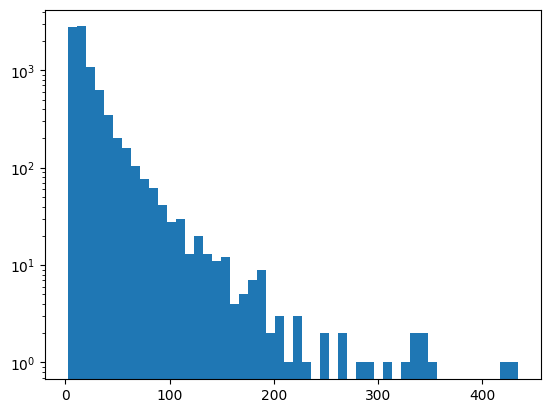

In [6]:
quantile_after = 0.75
print("This plot show the time difference between End time - Start time of the flares.")
print(f"Time difference {df_list['StEnd'].quantile(quantile_after)} (min) is upper {quantile_after*100}% quantile!")
plt.hist(df_list['StEnd'], log = True, bins = 50)
plt.show()

This plot show the time difference between End time of previous flare - Start time of the current flare.
Time difference 20.0 (min) is lower 10.0% quantile!


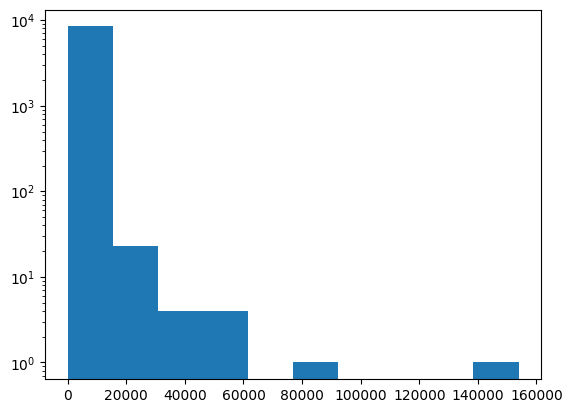

In [7]:
quantile_before = 0.1
print("This plot show the time difference between End time of previous flare - Start time of the current flare.")
print(f"Time difference {df_list['TdiffFL'].quantile(quantile_before)} (min) is lower {quantile_before*100}% quantile!")
# binwidth = 1000
# bins = plt.hist(df_list['TdiffFL'], log = True, bins=range(int(min(df_list['TdiffFL'])), int(max(df_list['TdiffFL'])) + binwidth, binwidth))
bins = plt.hist(df_list['TdiffFL'], log = True)
plt.show()

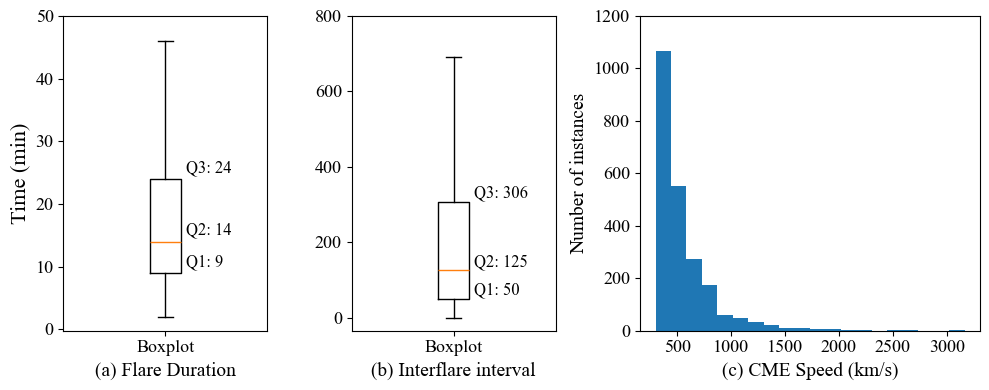

In [28]:
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": "Times New Roman"})

# plt.boxplot(df_list['StEnd'], showfliers=False)
fig, axis = plt.subplots(1, 3, figsize=(10, 4), gridspec_kw={'width_ratios': [0.9, 0.9, 1.5]})
# bp = sns.boxplot(data = df_list['StEnd'], showfliers=False, ax = axis[0], color = 'C0')
axis[0].boxplot(df_list['StEnd'], showfliers=False)
axis[0].set_yticks([0, 10, 20, 30, 40, 50])
axis[0].set_yticklabels(labels = [0, 10, 20, 30, 40, 50], fontsize=13)
axis[0].set_ylabel('Time (min)', fontsize = 16)
axis[0].set_xticklabels(labels = ['Boxplot'], fontsize = 13)
axis[0].set_xlabel('(a) Flare Duration', fontsize = 14)

q1_ax0 = df_list['StEnd'].quantile(0.25). round(2)
m_ax0 = df_list['StEnd'].quantile(0.5). round(2)
q3_ax0 = df_list['StEnd'].quantile(0.75). round(2)
axis[0].text(1.1, q1_ax0 + 1, s = f'Q1: {int(q1_ax0)}' , fontsize = 12)
axis[0].text(1.1, m_ax0 + 1, s = f'Q2: {int(m_ax0)}' , fontsize = 12)
axis[0].text(1.1, q3_ax0 + 1, s = f'Q3: {int(q3_ax0)}' , fontsize = 12)
    
# sns.boxplot(data = df_list['TdiffFL'], showfliers=False, ax = axis[1])
axis[1].boxplot(df_list.loc[df_list['TdiffFL'].notnull(), 'TdiffFL'], showfliers=False)
axis[1].set_yticks([0, 200, 400, 600, 800])
axis[1].set_yticklabels(labels = [0, 200, 400, 600, 800], fontsize=13)
axis[1].set_ylabel('', fontsize = 14)
axis[1].set_xticklabels(labels = ['Boxplot'], fontsize = 13)
axis[1].set_xlabel('(b) Interflare interval', fontsize = 14)

q1_ax1 = df_list['TdiffFL'].quantile(0.25). round(2)
m_ax1 = df_list['TdiffFL'].quantile(0.5). round(2)
q3_ax1 = df_list['TdiffFL'].quantile(0.75). round(2)
axis[1].text(1.1, q1_ax1 + 10, s = f'Q1: {int( q1_ax1 )}' , fontsize = 12)
axis[1].text(1.1, m_ax1 + 10, s = f'Q2: {int(m_ax1)}' , fontsize = 12)
axis[1].text(1.1, q3_ax1 + 10, s = f'Q3: {int( q3_ax1 )}' , fontsize = 12)

axis[2].hist(df_list['cme_vel'], bins = 20)
axis[2].set_yticks([0, 200, 400, 600, 800, 1000, 1200])
axis[2].set_yticklabels(labels = [0, 200, 400, 600, 800, 1000, 1200], fontsize=13)
axis[2].set_ylabel('Number of instances', fontsize = 14)
axis[2].set_xticks([500, 1000, 1500, 2000, 2500, 3000])
axis[2].set_xticklabels(labels = [500, 1000, 1500, 2000, 2500, 3000], fontsize = 13)
axis[2].set_xlabel('(c) CME Speed (km/s)', fontsize = 14)
fig.tight_layout()
plt.savefig("Flare_time_distribution.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [9]:
df_list.iloc[64:70, :]

,flare_id,start_time,peak_time,end_time,goes_class,noaa_active_region,fl_lon,fl_lat,fl_loc_src,ssw_flare_id,...,Flare_rise_time,Flare_decay_time,Flare_duration,rise_gradient,decay_gradient,avg_fluorescence,avg_rise_fluorescence,avg_decay_fluorescence,StEnd,TdiffFL
64,gid_sdo_67,2010-11-01 04:36:00,2010-11-01 04:43:00,2010-11-01 04:50:00,C1.1,NaN,NaN,NaN,XRT,NaN,...,7,7,14,1.398757e-07,-6.459000e-08,8.354714e-07,7.448029e-07,1.108854e-06,14.0,1440.0
66,gid_sdo_69,2010-11-03 05:54:00,2010-11-03 06:11:00,2010-11-03 06:26:00,C3.8,NaN,NaN,NaN,XRT,NaN,...,17,15,32,2.122106e-07,-1.225200e-07,2.418688e-06,1.928589e-06,3.231540e-06,32.0,2944.0
67,gid_sdo_70,2010-11-03 12:07:00,2010-11-03 12:21:00,2010-11-03 12:33:00,C4.9,NaN,NaN,NaN,XRT,NaN,...,14,12,26,3.321914e-07,-1.910583e-07,2.816388e-06,2.165356e-06,3.991192e-06,26.0,341.0
68,gid_sdo_71,2010-11-03 12:43:00,2010-11-03 13:08:00,2010-11-03 13:51:00,C3.4,NaN,NaN,NaN,XRT,NaN,...,25,43,68,4.289600e-08,-1.257907e-08,3.109941e-06,3.053580e-06,3.222063e-06,68.0,10.0
70,gid_sdo_73,2010-11-04 02:34:00,2010-11-04 02:53:00,2010-11-04 03:10:00,C1.0,11121.0,-82.211576,-20.0,GOES,NaN,...,19,17,36,3.517474e-08,-1.850529e-08,8.744575e-07,8.592474e-07,9.534276e-07,36.0,763.0
71,gid_sdo_74,2010-11-04 23:30:00,2010-11-04 23:58:00,2010-11-05 00:12:00,M1.6,11121.0,-76.000000,-20.0,GOES,NaN,...,28,14,42,5.631286e-07,-5.710500e-07,5.616287e-06,2.553806e-06,1.290318e-05,42.0,1220.0


In [10]:
# There are also negative X-ray flux, so these values should be removed.
df_xray.loc[df_xray['B_AVG'] < 0, :]

,Timestamp,B_AVG,B_filtered
6903,2010-01-05 19:03:00,-99999.0,NaN
8628,2010-01-06 23:48:00,-99999.0,NaN
8629,2010-01-06 23:49:00,-99999.0,NaN
8630,2010-01-06 23:50:00,-99999.0,NaN
8631,2010-01-06 23:51:00,-99999.0,NaN
...,...,...,...
4937863,2019-05-23 01:43:00,-99999.0,NaN
4937864,2019-05-23 01:44:00,-99999.0,NaN
4937865,2019-05-23 01:45:00,-99999.0,NaN
4937866,2019-05-23 01:46:00,-99999.0,NaN


In [11]:
# remove the rows which do not have cme velocity
df_er = df_list.loc[df_list['cme_vel'].notnull(), :]
df_er = df_er.loc[(df_er['Background_X-ray_flux'].notnull()) 
                 & (df_er['goes_class_num'].notnull()) & (df_er['fluorescence'] >= 0) 
                 & (df_er['rise_gradient'] >= 0),  :]

In [30]:
len(df_er)

2227

In [12]:
# Check class imbalance, 500 is a current threshold.
df_er = df_er.assign(label = np.where(df_er['cme_vel'] >= 500, 1, 0))
df_er['label'].value_counts()

label
0    1311
1     916
Name: count, dtype: int64

### CME speed distribution

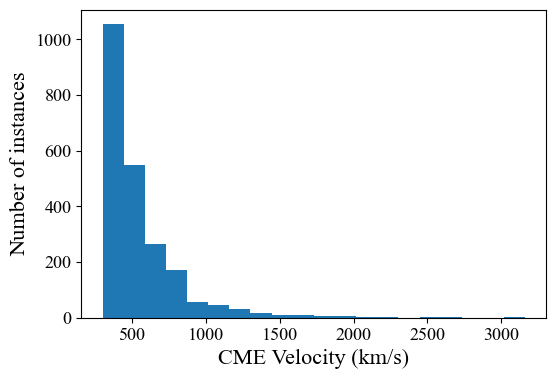

In [13]:
plt.figure(figsize=(6, 4))
plt.hist(df_er['cme_vel'], bins = 20)
plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)
plt.ylabel('Number of instances', fontsize = 16)
plt.xlabel('CME Velocity (km/s)', fontsize = 16)
plt.savefig("CME_Speed_distribution.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [14]:
len(df_er.loc[df_er['cme_vel'] >= 500, :]) 

916

In [15]:
len(df_er.loc[df_er['cme_vel'] < 500, :]) 

1311